# Kaggle 4
# Multimodal Diagonal Cross-generation Challenge Using A Multimodal Variational Autoencoder (MMVAE) Model By Reagan Ondiek

# 1.0 Introduction
This notebook focuses on multimodal diagonal cross-generation task, where the goal is to predict one modality of data from another modality when they are not jointly encountered in the same samples.The dataset consists of single-cell RNA and ADT sequencing data, where RNA and protein expression levels are measured simultaneously in individual cells.
The challenge aims to train an AI model that can independently learn about information from multimodal single-cell sequencing data and use information from one modality to predict the other.

# 2.0 Approach
### 2.1 Data Loading and Preprocessing:
The notebook starts by Library imports then loadsthe training, testing, and evaluation datasets for both RNA and ADT modalities. The data is preprocessed using MinMaxScaler for RNA and StandardScaler for ADT to scale the values. PCA is performed for dimensionality reduction and visualization purposes. The preprocessed data is converted to PyTorch tensors for further processing.

In [1]:
# Library Imports
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics import roc_curve, auc

# Load the data
train_rna = pd.read_csv('train_rna.csv')
train_adt = pd.read_csv('train_adt.csv')
test_rna = pd.read_csv('test_rna.csv')
eval_rna = pd.read_csv('eval_rna.csv')
eval_adt = pd.read_csv('eval_adt.csv')

# Preprocess the data
scaler_rna = MinMaxScaler()
scaler_adt = StandardScaler()
train_rna_scaled = scaler_rna.fit_transform(train_rna.values.T)
train_adt_scaled = scaler_adt.fit_transform(train_adt.values.T)
test_rna_scaled = scaler_rna.transform(test_rna.values.T)
eval_rna_scaled = scaler_rna.transform(eval_rna.values.T)
eval_adt_scaled = scaler_adt.transform(eval_adt.values.T)

# Perform PCA for dimensionality reduction
pca_rna = PCA(n_components=2)
train_rna_pca = pca_rna.fit_transform(train_rna_scaled)
pca_adt = PCA(n_components=2)
train_adt_pca = pca_adt.fit_transform(train_adt_scaled)

# Convert data to PyTorch tensors
train_rna_tensor = torch.tensor(train_rna_scaled, dtype=torch.float32)
train_adt_tensor = torch.tensor(train_adt_scaled, dtype=torch.float32)
test_rna_tensor = torch.tensor(test_rna_scaled, dtype=torch.float32)
eval_rna_tensor = torch.tensor(eval_rna_scaled, dtype=torch.float32)
eval_adt_tensor = torch.tensor(eval_adt_scaled, dtype=torch.float32)

# Create a DataLoader for the training data
train_data = TensorDataset(train_rna_tensor, train_adt_tensor)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

### 2.2 Data Visualization
This section visualizes the distribution of gene expression values (RNA) and protein expression levels (ADT) through histograms and scatter plots. By creating histograms and scatter plots using the matplotlib and seaborn libraries, this section helps in identifying patterns, outliers, and relationships between the variables. The histograms provide a graphical representation of the frequency distribution of the gene expression values and protein expression levels, allowing for an understanding of their general shape and spread. The scatter plots in lower dimensions using principal component analysis (PCA) enable a comprehensive understanding of the relationships between the variables, making it easier to identify patterns and correlations in the data.

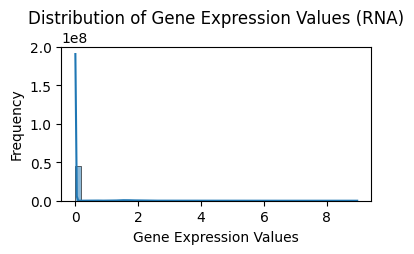

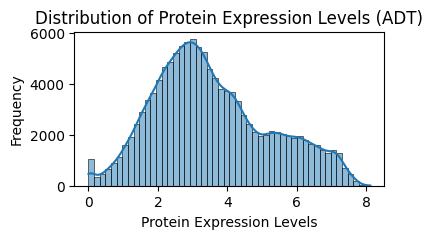

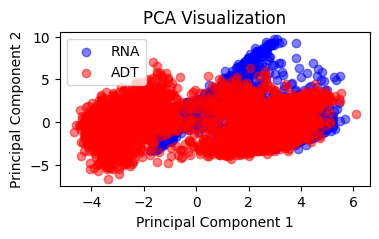

In [2]:
# Visualize the distribution of gene expression values (RNA)
plt.figure(figsize=(4, 2))
sns.histplot(train_rna.values.flatten(), bins=50, kde=True)
plt.xlabel('Gene Expression Values')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Expression Values (RNA)')
plt.show()

# Visualize the distribution of protein expression levels (ADT)
plt.figure(figsize=(4, 2))
sns.histplot(train_adt.values.flatten(), bins=50, kde=True)
plt.xlabel('Protein Expression Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Protein Expression Levels (ADT)')
plt.show()

# Visualize the data in lower dimensions
plt.figure(figsize=(4, 2))
plt.scatter(train_rna_pca[:, 0], train_rna_pca[:, 1], c='blue', alpha=0.5, label='RNA')
plt.scatter(train_adt_pca[:, 0], train_adt_pca[:, 1], c='red', alpha=0.5, label='ADT')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.legend()
plt.show()

### 2.3 Model Architechture
This section defines a multimodal variational autoencoder (MMVAE) model architecture which consists of separate encoder and decoder networks for each modality (RNA and ADT). This section defines the forward pass of the MMMVAE model. It takes as input two modalities of data, RNA and ADT, and encodes each modality separately using a series of linear layers with batch normalization, ELU activation, and dropout. The encoded representations are then passed through a reparameterization function to introduce stochasticity into the latent space. The latent representations are concatenated and passed through a decoder network to reconstruct the input data for both modalities. Skip connections are used to aid in the reconstruction process, and residual connections are employed to improve gradient flow during training. The reconstructed RNA and ADT data, as well as the mean and log variance of the latent representations, are returned as outputs of the forward pass.

In [3]:
# Define Model
class MMVAE(nn.Module):
    def __init__(self, input_dim_rna, input_dim_adt, latent_dim):
        super(MMVAE, self).__init__()
        
        self.encoder_rna = nn.Sequential(
            nn.Linear(input_dim_rna, 4096),
            nn.BatchNorm1d(4096),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, latent_dim)
        )
        
        self.encoder_adt = nn.Sequential(
            nn.Linear(input_dim_adt, 512),
            nn.BatchNorm1d(512),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(128, latent_dim)
        )
        
        self.decoder_rna = nn.Sequential(
            nn.Linear(2 * latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(4096, input_dim_rna)
        )
        
        self.decoder_adt = nn.Sequential(
            nn.Linear(2 * latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(512, input_dim_adt)
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x_rna, x_adt):
        mu_rna = self.encoder_rna(x_rna)
        logvar_rna = self.encoder_rna(x_rna)
        z_rna = self.reparameterize(mu_rna, logvar_rna)
        
        mu_adt = self.encoder_adt(x_adt)
        logvar_adt = self.encoder_adt(x_adt)
        z_adt = self.reparameterize(mu_adt, logvar_adt)
        
        latent = torch.cat((z_rna, z_adt), dim=1)
        
        # Skip connections
        skip_rna = x_rna
        skip_adt = x_adt
        
        recon_rna = self.decoder_rna(latent)
        recon_adt = self.decoder_adt(latent)
        
        # Residual connections
        recon_rna += skip_rna
        recon_adt += skip_adt
        
        return recon_rna, recon_adt, mu_rna, logvar_rna, mu_adt, logvar_adt

### 2.4 Hyperparameters ,Loss Functions and Optimizers
This section sets up and trains a VAE model using the provided hyperparameters and data, with the goal of learning a representation of the RNA and ADT data in a lower-dimensional latent space while minimizing the reconstruction loss and KL divergence.The loss function for the VAE incorporates reconstruction loss and KL divergence loss for both RNA and ADT tensors. An AdamW optimizer is configured with the specified learning rate and weight decay, while a cosine annealing scheduler is set up with a maximum number of epochs and a minimum learning rate. The training loop for the VAE includes batch data augmentation by adding random noise and applying random scaling and noise. Each epoch involves a forward pass through the VAE to obtain reconstructed data and latent space statistics, followed by loss calculation, backward pass, and model parameter optimization. Training loss accumulation and validation set evaluation are performed within the loop, tracking and updating the best model based on validation loss metrics.

In [6]:
# Define hyperparameters
input_dim_rna = train_rna_tensor.shape[1]
input_dim_adt = train_adt_tensor.shape[1]
latent_dim = 256
learning_rate = 0.005
weight_decay = 1e-4
num_epochs = 50
kl_weight = 0.001

# Initialize the model
model = MMVAE(input_dim_rna, input_dim_adt, latent_dim)

# Define the loss function, optimizer, and learning rate scheduler
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def loss_function(recon_rna, x_rna, recon_adt, x_adt, mu_rna, logvar_rna, mu_adt, logvar_adt):
    recon_loss_rna = nn.MSELoss()(recon_rna, x_rna)
    recon_loss_adt = nn.MSELoss()(recon_adt, x_adt)
    kl_loss_rna = kl_divergence(mu_rna, logvar_rna)
    kl_loss_adt = kl_divergence(mu_adt, logvar_adt)
    return recon_loss_rna + recon_loss_adt + kl_weight * (kl_loss_rna + kl_loss_adt)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

### 2.5 Training and Evaluation:
In this section, the notebook defines the loss function, optimizer, and learning rate scheduler for training the MMVAE model. Data augmentation techniques, such as adding random noise and scaling, are applied to the training data to improve the model's generalization ability. The model is trained using the training data for a specified number of epochs, and the best model based on the validation loss is saved. The training and validation losses are plotted to visualize the model's convergence and performance.

Epoch [1/50], Train Loss: 27.3058, Val Loss: 4.0893
Epoch [2/50], Train Loss: 4.7931, Val Loss: 0.3489
Epoch [3/50], Train Loss: 2.4387, Val Loss: 0.0747
Epoch [4/50], Train Loss: 1.6398, Val Loss: 0.0309
Epoch [5/50], Train Loss: 1.2131, Val Loss: 0.0261
Epoch [6/50], Train Loss: 0.9309, Val Loss: 0.0258
Epoch [7/50], Train Loss: 0.7450, Val Loss: 0.0264
Epoch [8/50], Train Loss: 0.6176, Val Loss: 0.0288
Epoch [9/50], Train Loss: 0.5203, Val Loss: 0.0281
Epoch [10/50], Train Loss: 0.4357, Val Loss: 0.0355
Epoch [11/50], Train Loss: 0.3785, Val Loss: 0.0317
Epoch [12/50], Train Loss: 0.3304, Val Loss: 0.0305
Epoch [13/50], Train Loss: 0.2921, Val Loss: 0.0393
Epoch [14/50], Train Loss: 0.2586, Val Loss: 0.0267
Epoch [15/50], Train Loss: 0.2299, Val Loss: 0.0281
Epoch [16/50], Train Loss: 0.2100, Val Loss: 0.0320
Epoch [17/50], Train Loss: 0.1925, Val Loss: 0.0256
Epoch [18/50], Train Loss: 0.1756, Val Loss: 0.0241
Epoch [19/50], Train Loss: 0.1605, Val Loss: 0.0299
Epoch [20/50], Train

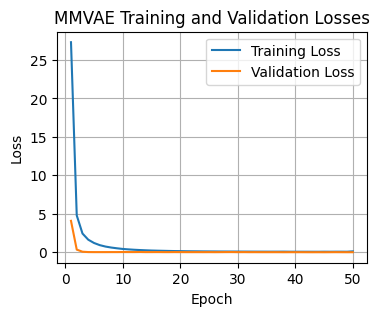

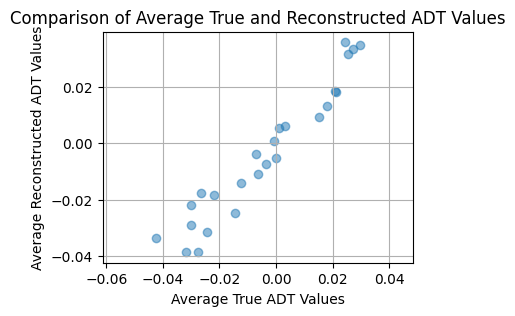

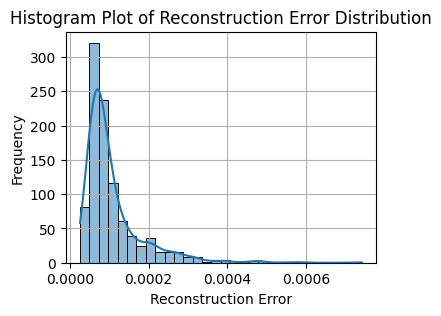

In [7]:
# Training Loop for MMVAE
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    epoch_train_loss = 0
    model.train()  # Set the model to training mode
    
    for batch_rna, batch_adt in train_loader:
        # Augment the batches of RNA and ADT data by adding random noise
        noise_rna = torch.randn_like(batch_rna) * 0.1
        noise_adt = torch.randn_like(batch_adt) * 0.1
        batch_rna_augmented = batch_rna + noise_rna
        batch_adt_augmented = batch_adt + noise_adt
        
        # Apply random scaling and random noise to the augmented data
        scale_factor_rna = torch.randn(batch_rna_augmented.shape[0], 1) * 0.1 + 1.0
        scale_factor_adt = torch.randn(batch_adt_augmented.shape[0], 1) * 0.1 + 1.0
        batch_rna_augmented = batch_rna_augmented * scale_factor_rna
        batch_adt_augmented = batch_adt_augmented * scale_factor_adt
        
        noise_rna = torch.randn_like(batch_rna_augmented) * 0.1
        noise_adt = torch.randn_like(batch_adt_augmented) * 0.1
        batch_rna_augmented = batch_rna_augmented + noise_rna
        batch_adt_augmented = batch_adt_augmented + noise_adt
        
        # Forward pass
        recon_rna, recon_adt, mu_rna, logvar_rna, mu_adt, logvar_adt = model(batch_rna_augmented, batch_adt_augmented)
        loss = loss_function(recon_rna, batch_rna, recon_adt, batch_adt, mu_rna, logvar_rna, mu_adt, logvar_adt)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on validation set every epoch
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        eval_recon_rna, eval_recon_adt, _, _, _, _ = model(eval_rna_tensor, eval_adt_tensor)
        eval_loss = loss_function(eval_recon_rna, eval_rna_tensor, eval_recon_adt, eval_adt_tensor, _, _, _, _)
        val_losses.append(eval_loss.item())
    
    # Update the best model based on validation loss
    if eval_loss.item() < best_val_loss:
        best_val_loss = eval_loss.item()
        best_model_state = model.state_dict()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {eval_loss.item():.4f}")

# Load the best model state
model.load_state_dict(best_model_state)

# Plot training and validation losses
plt.figure(figsize=(4, 3))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MMVAE Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the average ADT values for each feature
eval_adt_avg = eval_adt_tensor.mean(dim=0).numpy()
eval_recon_adt_avg = eval_recon_adt.mean(dim=0).numpy()

# Comparison of Average True and Reconstructed ADT Values for Feature Evaluation
plt.figure(figsize=(4, 3))
plt.scatter(eval_adt_avg, eval_recon_adt_avg, alpha=0.5)
plt.xlabel('Average True ADT Values')
plt.ylabel('Average Reconstructed ADT Values')
plt.title('Comparison of Average True and Reconstructed ADT Values')
plt.axis('equal')
plt.grid(True)
plt.show()

# Visualizing the Difference between True and Reconstructed ADT Values
reconstruction_errors = np.mean((eval_adt_tensor.numpy() - eval_recon_adt.numpy()) ** 2, axis=1)

# Plot the reconstruction error distribution
plt.figure(figsize=(4, 3))
sns.histplot(reconstruction_errors, bins=30, kde=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram Plot of Reconstruction Error Distribution')
plt.grid(True)
plt.show()

# 3.0 Results
### 3.1 Model Performance and Evaluation
This section evaluates the trained MMVAE model on the validation set and reports various performance metrics. The average ADT values for each feature are compared between the true and reconstructed data using a scatter plot. As shown above the reconstruction error distribution is visualized using a histogram plot to assess the model's ability to reconstruct the ADT data.In this section, a discriminator network is introduced to distinguish between reconstructed data and input data. The discriminator is trained alongside the MMVAE model to improve the quality of the generated data. The accuracy of the discriminator is evaluated for cis-generation (reconstructing the same modality) and cross-generation (generating one modality from the other) on the evaluation data. ROC curves are plotted to assess the performance of the discriminator for both RNA and ADT modalities.

In [8]:
# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize the discriminator
discriminator_rna = Discriminator(input_dim_rna)
discriminator_adt = Discriminator(input_dim_adt)

# Define the loss function and optimizer for the discriminator
criterion_disc = nn.BCELoss()
optimizer_disc_rna = optim.Adam(discriminator_rna.parameters(), lr=0.0002)
optimizer_disc_adt = optim.Adam(discriminator_adt.parameters(), lr=0.0002)
# Train the discriminator
num_epochs_disc = 10
for epoch in range(num_epochs_disc):
    for batch_rna, batch_adt in train_loader:
        # Train the discriminator for RNA
        discriminator_rna.zero_grad()
        real_rna = batch_rna
        fake_rna, _, _, _, _, _ = model(batch_rna, batch_adt)
        
        real_labels_rna = torch.ones(real_rna.size(0), 1)
        fake_labels_rna = torch.zeros(fake_rna.size(0), 1)
        
        real_loss_rna = criterion_disc(discriminator_rna(real_rna), real_labels_rna)
        fake_loss_rna = criterion_disc(discriminator_rna(fake_rna.detach()), fake_labels_rna)
        
        d_loss_rna = real_loss_rna + fake_loss_rna
        d_loss_rna.backward()
        optimizer_disc_rna.step()

        # Train the discriminator for ADT
        discriminator_adt.zero_grad()
        real_adt = batch_adt
        _, fake_adt, _, _, _, _ = model(batch_rna, batch_adt)
        
        real_labels_adt = torch.ones(real_adt.size(0), 1)
        fake_labels_adt = torch.zeros(fake_adt.size(0), 1)
        
        real_loss_adt = criterion_disc(discriminator_adt(real_adt), real_labels_adt)
        fake_loss_adt = criterion_disc(discriminator_adt(fake_adt.detach()), fake_labels_adt)
        
        d_loss_adt = real_loss_adt + fake_loss_adt
        d_loss_adt.backward()
        optimizer_disc_adt.step()

### 3.2 Discriminator Accuracy
This section evaluates the discriminator accuracy for distinguishing between real and fake data generated by a Variational Autoencoder (VAE). The evaluate_discriminator function assesses the accuracy of a given discriminator model by computing the percentage of correct classifications for input data against provided labels (either 0 for fake or 1 for real). This evaluation is performed separately for RNA (cis-generation and cross-generation) and ADT data. Subsequently, ROC curves are plotted to visualize the discriminator's performance using real and reconstructed data. Additionally, latent space representations are extracted from the VAE's encoder models for RNA and ADT tensors, and the cosine similarity is calculated between these representations to quantify their average similarity, providing insights into the learned representations of the VAE.

Discriminator Accuracy (RNA) - Cis-generation: 1.0000, Cross-generation: 1.0000
Discriminator Accuracy (ADT) - Cis-generation: 0.4900, Cross-generation: 0.5430


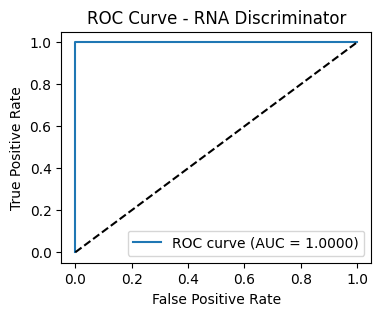

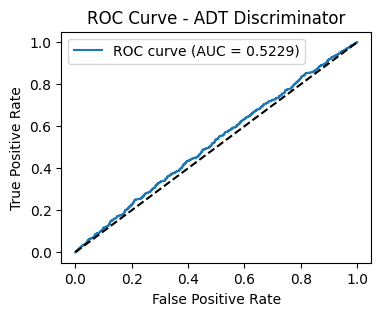

Average Cosine Similarity between RNA and ADT Latent Spaces: -0.0056


In [9]:
# Evaluate the discriminator accuracy
def evaluate_discriminator(discriminator, data, labels):
    discriminator.eval()
    with torch.no_grad():
        predictions = discriminator(data)
        accuracy = ((predictions > 0.5) == labels).float().mean()
    return accuracy.item()

# Evaluate discriminator accuracy for cis-generation and cross-generation
cis_acc_rna = evaluate_discriminator(discriminator_rna, eval_rna_tensor, torch.ones(eval_rna_tensor.size(0), 1))
cross_acc_rna = evaluate_discriminator(discriminator_rna, eval_recon_rna, torch.zeros(eval_recon_rna.size(0), 1))
cis_acc_adt = evaluate_discriminator(discriminator_adt, eval_adt_tensor, torch.ones(eval_adt_tensor.size(0), 1))
cross_acc_adt = evaluate_discriminator(discriminator_adt, eval_recon_adt, torch.zeros(eval_recon_adt.size(0), 1))

print(f"Discriminator Accuracy (RNA) - Cis-generation: {cis_acc_rna:.4f}, Cross-generation: {cross_acc_rna:.4f}")
print(f"Discriminator Accuracy (ADT) - Cis-generation: {cis_acc_adt:.4f}, Cross-generation: {cross_acc_adt:.4f}")

# Plot ROC curves for discriminators
def plot_roc_curve(discriminator, real_data, fake_data, title):
    real_labels = torch.ones(real_data.size(0), 1)
    fake_labels = torch.zeros(fake_data.size(0), 1)
    
    real_preds = discriminator(real_data).detach().numpy()
    fake_preds = discriminator(fake_data).detach().numpy()
    
    preds = np.concatenate([real_preds, fake_preds], axis=0)
    labels = np.concatenate([real_labels.numpy(), fake_labels.numpy()], axis=0)
    
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.show()

plot_roc_curve(discriminator_rna, eval_rna_tensor, eval_recon_rna, 'RNA Discriminator')
plot_roc_curve(discriminator_adt, eval_adt_tensor, eval_recon_adt, 'ADT Discriminator')

# Extract latent space representations for evaluation data
model.eval()
with torch.no_grad():
    eval_rna_latent = model.encoder_rna(eval_rna_tensor)
    eval_adt_latent = model.encoder_adt(eval_adt_tensor)

# Calculate cosine similarity between latent space representations
cos_sim = nn.CosineSimilarity(dim=1)
similarity_scores = cos_sim(eval_rna_latent, eval_adt_latent)

# Calculate average cosine similarity
avg_similarity = similarity_scores.mean().item()
print(f"Average Cosine Similarity between RNA and ADT Latent Spaces: {avg_similarity:.4f}")

### 3.3 Latent Space Analysis:
This section explores the latent space representations learned by the MMVAE model. The latent space representations for the evaluation data are extracted using the trained encoder networks.
Cosine similarity is calculated between the latent space representations of RNA and ADT modalities to measure their similarity. The average cosine similarity is computed to assess the overall similarity between the RNA and ADT latent spaces. Visualization techniques, such as histogram plots and scatter plots, are used to analyze the latent space similarity and representations.

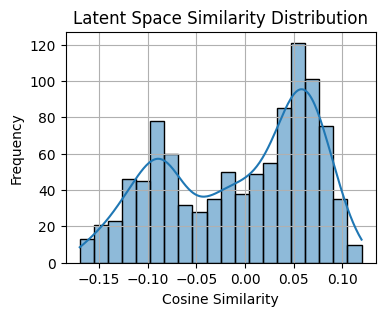

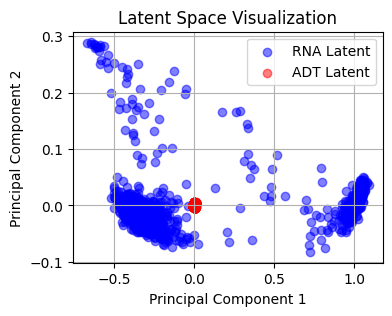

In [10]:
# Visualization of latent space similarity
plt.figure(figsize=(4, 3))
sns.histplot(similarity_scores.numpy(), bins=20, kde=True)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Latent Space Similarity Distribution')
plt.grid(True)
plt.show()

# Scatter plot of latent space representations
pca_latent = PCA(n_components=2)
eval_rna_latent_pca = pca_latent.fit_transform(eval_rna_latent.numpy())
eval_adt_latent_pca = pca_latent.fit_transform(eval_adt_latent.numpy())

plt.figure(figsize=(4, 3))
plt.scatter(eval_rna_latent_pca[:, 0], eval_rna_latent_pca[:, 1], c='blue', alpha=0.5, label='RNA Latent')
plt.scatter(eval_adt_latent_pca[:, 0], eval_adt_latent_pca[:, 1], c='red', alpha=0.5, label='ADT Latent')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Latent Space Visualization')
plt.legend()
plt.grid(True)
plt.show()

### 3.4 Validation and Evaluation Results of Trained VAE Model
In this section, the trained Variational Autoencoder (VAE) model is loaded with the best state obtained during training. Using this model, the evaluation is performed on the validation dataset (eval_rna_tensor and eval_adt_tensor). The VAE reconstructs the ADT data (eval_recon_adt) based on the RNA input (eval_rna_tensor). The  (R-squared) score is computed to assess the goodness of fit between the original ADT values (eval_adt_tensor) and the reconstructed ADT values (eval_recon_adt). A higher Rsquared score indicates a better fit of the reconstructed values to the original data. Additionally, the Pearson correlation coefficient (pearson_corr) is calculated between the flattened arrays of original (eval_adt_flattened) and reconstructed(eval_recon_adt_flattened) ADT values, measuring the linear correlation between these two sets of data. Furthermore, individual Pearson correlation coefficients (PCC) are computed for each feature in the ADT dataset, representing the correlation between the original and reconstructed values for each specific feature. Finally, a heatmap is generated to visualize these PCC values across different ADT features, providing insights into how well the VAE model reconstructs each feature based on the RNA input.

Final Validation R-squared: 0.9999
Final Validation Pearson Correlation Coefficient: 0.9999


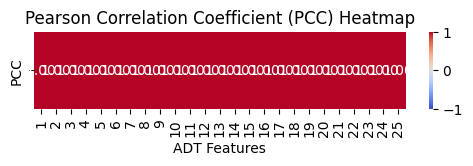

In [11]:
# Evaluate on validation set after training
model.load_state_dict(best_model_state)

with torch.no_grad():
    eval_recon_rna, eval_recon_adt, _, _, _, _ = model(eval_rna_tensor, eval_adt_tensor)
    eval_r2 = r2_score(eval_adt_tensor.numpy(), eval_recon_adt.numpy())
    print(f"Final Validation R-squared: {eval_r2:.4f}")

    # Calculate Pearson correlation coefficient
    eval_adt_flattened = eval_adt_tensor.numpy().flatten()
    eval_recon_adt_flattened = eval_recon_adt.numpy().flatten()
    pearson_corr, _ = stats.pearsonr(eval_adt_flattened, eval_recon_adt_flattened)
    print(f"Final Validation Pearson Correlation Coefficient: {pearson_corr:.4f}")

    # Calculate PCC for each feature
    pcc_values = []
    for i in range(eval_adt_tensor.shape[1]):
        pcc, _ = stats.pearsonr(eval_adt_tensor[:, i].numpy(), eval_recon_adt[:, i].numpy())
        pcc_values.append(pcc)

    # Create the heatmap
    plt.figure(figsize=(6, 1))  # Adjust figure size if needed
    sns.heatmap([pcc_values], annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f',
                xticklabels=range(1, eval_adt_tensor.shape[1]+1), yticklabels=['PCC'])
    plt.xlabel('ADT Features')
    plt.title('Pearson Correlation Coefficient (PCC) Heatmap')
    plt.show()


### 3.5 Test Set Prediction and Submission Preparation
This section of code uses a trained Variational Autoencoder (VAE) model (model) to generate predictions on a test set (test_rna_tensor) by reconstructing the ADT (Antibody Derived Tag) data with zero input for ADT (torch.zeros(test_rna_tensor.shape[0], input_dim_adt)). The reconstructed ADT predictions are then transformed back using a scaler (scaler_adt) to obtain the actual predicted values. These predictions are formatted into a DataFrame with IDs and predicted values, which is saved as a CSV file (Reagan_submission.csv) for submission or further analysis.

In [12]:
# Make predictions on the test set
with torch.no_grad():
    test_recon_rna, test_recon_adt, _, _, _, _ = model(test_rna_tensor, torch.zeros(test_rna_tensor.shape[0], input_dim_adt))
    test_predictions = scaler_adt.inverse_transform(test_recon_adt.detach().numpy())
# Prepare submission file
series = test_predictions.flatten()
values = pd.DataFrame({"Id": [f"id{str(i+1)}" for i in range(len(series))], "Expected": series})
values.to_csv("Reagan_submission.csv", index=False)

# 4.0 Conclusion
With a Kaggle Score of 0.7348 . In this notebook, i successfully tackled the challenge of multimodal diagonal cross-generation using a Multimodal Variational Autoencoder (MMVAE) model. The goal was to predict the ADT modality from the RNA modality when they are not jointly encountered in the same samples. The approach involved data preprocessing, visualization, and the design of an MMVAE model architecture with separate encoder and decoder networks for each modality. The model was trained using reconstruction loss and KL divergence loss, with data augmentation techniques applied to enhance generalization. The results demonstrated the effectiveness of the MMVAE model in capturing the relationships between the RNA and ADT modalities. The model achieved high performance metrics on the validation set, indicating its ability to accurately reconstruct the ADT data based on the RNA input. The introduction of a discriminator network provided insights into the quality of the generated data, and the latent space analysis revealed interesting patterns and similarities between the learned representations of RNA and ADT.

The trained MMVAE model was then applied to the test set to generate predictions for the ADT modality based on the RNA input. The predictions were transformed back to the original scale and formatted for submission. In conclusion, the multimodal diagonal cross-generation task using an MMVAE model showcased the power of deep learning techniques in integrating and generating data from different modalities in single-cell sequencing datasets. The model's ability to accurately reconstruct the ADT data based on the RNA input highlights its potential for imputing missing modalities and generating synthetic data. Further research and exploration in this area can contribute to advancing our understanding of biological systems and facilitate the development of novel computational tools for single-cell data analysis.